# TSP usando Simulated Annealing

## Imports

In [25]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore")

## Funções

In [2]:
# Funções auxiliares

def euclidean_dist(x,y) -> float:
    return np.linalg.norm(x-y,2)

def create_new_path(curr_path:np.ndarray,start_idx:int,end_idx:int) -> np.ndarray:
    
    new_path = curr_path.copy()
    
    for k in range(len(curr_path)):
        if k >= start_idx and k <= end_idx:
            new_path[k] = curr_path[end_idx-k+start_idx]
        else:
            new_path[k] = curr_path[k]
            
    return new_path

def compute_dist(path:np.ndarray,dist_matrix:np.ndarray)->float:
    dist = sum([dist_matrix[path[i],path[i+1]] for i in range(len(path)-1)])
    dist += dist_matrix[path[-1],path[0]]
    return dist

def compute_dist_diff(path:np.ndarray,new_path:np.ndarray,
                      start_idx:int,end_idx:int,dist_matrix:np.ndarray)->float:
    left_idx = start_idx - 1
    right_idx = end_idx + 1
    path_size = len(path)
    
    if left_idx < 0: left_idx = path_size-1
    if right_idx >= path_size: right_idx = 0
    
    dist_diff = - dist_matrix[path[left_idx],path[start_idx]] \
                - dist_matrix[path[right_idx],path[end_idx]] \
                + dist_matrix[new_path[left_idx],new_path[start_idx]] \
                + dist_matrix[new_path[right_idx],new_path[end_idx]]
    return dist_diff
    

In [3]:
# Funções específicas do tsp

def create_tsp_sample(num_cities:int,random_seed:int)->tuple:
    np.random.seed(random_seed)

    city_coord = np.random.uniform(0,1,[num_cities,2])

    dist_matrix = np.zeros([num_cities,num_cities])
    for i in range(num_cities):
        for j in range(num_cities):
            dist_matrix[i,j] = euclidean_dist(city_coord[i],city_coord[j])
    return city_coord,dist_matrix

def tsp_metropolis(init_path:np.ndarray,dist_matrix:np.ndarray,num_mc_steps:int,
                                   temperature:float,dt:float,final_temperature:float,
                                   steps_per_temp:int,step_to_sample:int,random_seed:int)->tuple:
    
    curr_path = init_path.copy()

    dists = [compute_dist(curr_path,dist_matrix)]
    temp_change_points = []
    sample_path = None

    for curr_step in range(num_mc_steps):

        swap_idx = np.random.choice(curr_path,2,replace=False)
        start_idx = np.min(swap_idx)
        end_idx = np.max(swap_idx)

        new_path = create_new_path(curr_path,start_idx,end_idx)

        dist_diff = compute_dist_diff(curr_path,new_path,start_idx,end_idx,dist_matrix)
        path_prob = np.exp((-dist_diff)/temperature,dtype=np.longdouble)

        if np.random.uniform(0,1) < path_prob:
            curr_path = new_path

        if temperature >= final_temperature and (curr_step+1) % steps_per_temp == 0:
            temperature = temperature * dt
            temp_change_points.append([curr_step,compute_dist(curr_path,dist_matrix)])
        if curr_step == step_to_sample:
            sample_path = curr_path

        dists.append(compute_dist(curr_path,dist_matrix))
        
    return np.array(dists),np.array(temp_change_points),curr_path,sample_path

In [4]:
# Função que realiza os experimentos

def run_experiments(city_coord:np.ndarray,dist_matrix:np.ndarray,num_mc_steps:int,
                    temperature:float,dt:float,steps_per_temp:int,final_temperature:float,
                    num_samples:int,step_to_sample:int)->None:
    best_path = None
    best_path_dist = np.inf
    best_path_dists = None
    best_path_temp_change = None
    best_path_sample = None

    for random_seed in tqdm(np.arange(0,num_samples,1)):
        np.random.seed(random_seed)
        init_path = np.arange(0,num_cities,1)
        np.random.shuffle(init_path)

        dists,temp_change_points,final_path,sample_path = tsp_metropolis(init_path,dist_matrix,num_mc_steps,
                                           temperature,dt,final_temperature,
                                           steps_per_temp,step_to_sample,random_seed)

        curr_path_dist = compute_dist(final_path,dist_matrix)

        if curr_path_dist < best_path_dist:
            best_path = final_path
            best_path_dist = curr_path_dist

            best_path_dists = dists
            best_path_temp_change = temp_change_points
            best_path_sample = sample_path

    plot_dist_evolution(best_path_dists,best_path_temp_change,
                            num_cities,temperature,final_temperature,dt)

    plot_path(city_coord,init_path,f"Init path (dist = {compute_dist(init_path,dist_matrix):.2f})")
    plot_path(city_coord,best_path_sample,f"Sample path (Step={step_to_sample}) (dist = {compute_dist(best_path_sample,dist_matrix):.2f})")
    plot_path(city_coord,best_path,f"Final path (dist = {compute_dist(best_path,dist_matrix):.2f})")

In [5]:
# Funções para plotar
def drawArrow(A, B)->None:
    plt.arrow(A[0], A[1], B[0] - A[0], B[1] - A[1],width=0.00001,
              head_width=0.02, head_length=0.02, color='black',length_includes_head=True)
    
def plot_path(city_coord:np.ndarray,curr_path:np.ndarray,title:str)->None:

    num_cities = len(curr_path)
    plt.plot(city_coord[:,0],city_coord[:,1],'bo')
    plt.plot(city_coord[curr_path[0],0],city_coord[curr_path[0],1],'ro',label='Start point')
    for idx in range(num_cities):
        
        curr_point = city_coord[curr_path[idx],:]
        next_point = city_coord[curr_path[(idx + 1) % num_cities],:]
        drawArrow(curr_point,next_point)

    plt.ylabel("Y coordinate")
    plt.xlabel("X coordinate")
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_dist_evolution(dists:np.ndarray,temp_changes:np.ndarray,
                        num_cities:int,temperature:float,final_temperature:float,dt:float)->None:
    plt.plot(dists,'r')
    plt.plot(temp_changes[:,0],temp_changes[:,1],'bo',ms=3,label='Temp. change points')


    plt.title(f"Distance evolution (size={num_cities},init_temp={temperature:.2f},final_temp={final_temperature},dt={dt})")
    plt.xlabel("Monte Carlo Steps")
    plt.ylabel("Path distance (energy)")
    plt.legend()
    plt.show()
    

## Experimentos
Os experimentos abaixo irão realizar uma simulação do tsp por meio do método de simulated annealing. Definimos uma distribuição inicial de pontos, e então realizamos um número de passos de monte carlo e acomapanhamos a evolução da distância total do caminho em função dos passos, sendo que a cada x passos nós diminuímos a temperatura. Além disso, para cada experimento, realizamos n simulações com condições iniciais diferentes, e então selecionamos aquela com menor distância do caminho final como a melhor obtida.

### Experimento 1

Nesse experimento, iremos testar o problema para 10 cidades. Iremos testar a simulação em duas temperaturas iniciais diferentes (1 e 5).

In [6]:
# Parâmetros para geração dos dados
data_seed = 2022
num_cities = 10

city_coord,dist_matrix = create_tsp_sample(num_cities,data_seed)

In [7]:
# Parâmetros para a simulação do TSP
num_mc_steps = 4000 # Passos de monte carlo
temperature = 1 # Temperatura inicial
dt = 0.8 # delta da temperatura, que será utilizado para fazer temp = temp * dt
steps_per_temp = 100 # passos entre aplicação do delta
final_temperature = 0.0005 # temperatura final
num_samples = 50 # número de amostras, i.e., caminhos iniciais distintos, a serem considerados na simulação
step_to_sample = 1000 # passo de monte carlo que será amostrado para comparação

  0%|          | 0/50 [00:00<?, ?it/s]

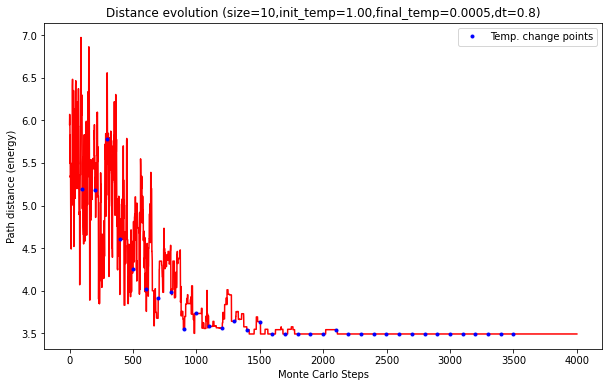

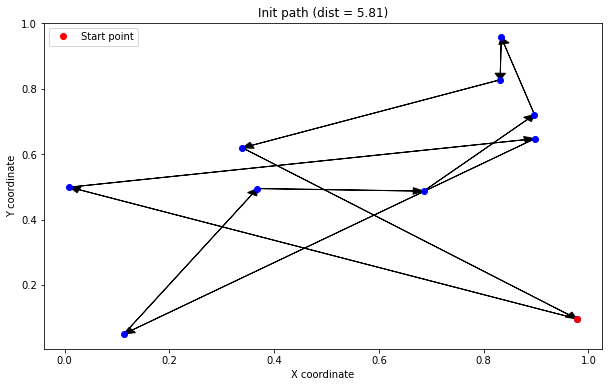

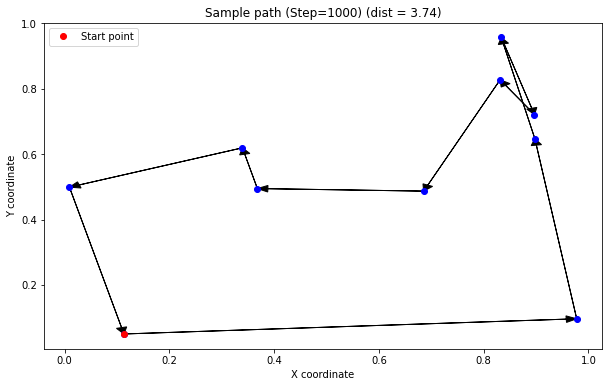

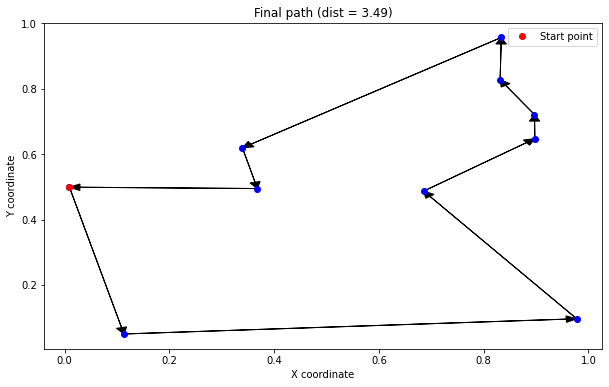

In [8]:
run_experiments(city_coord,dist_matrix,num_mc_steps,
                    temperature,dt,steps_per_temp,final_temperature,
                    num_samples,step_to_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

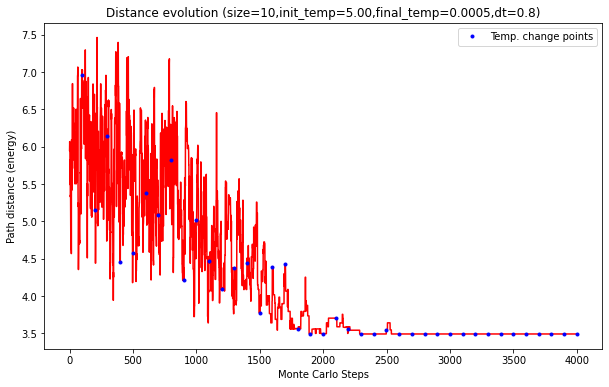

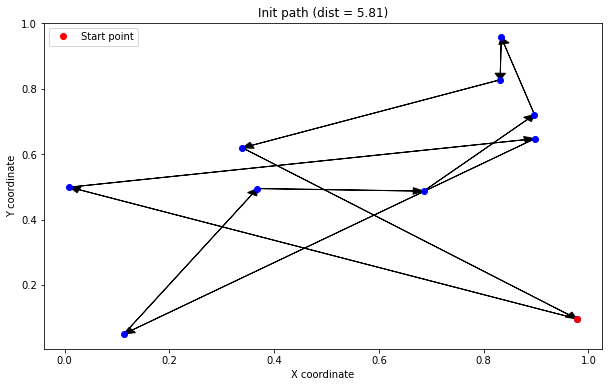

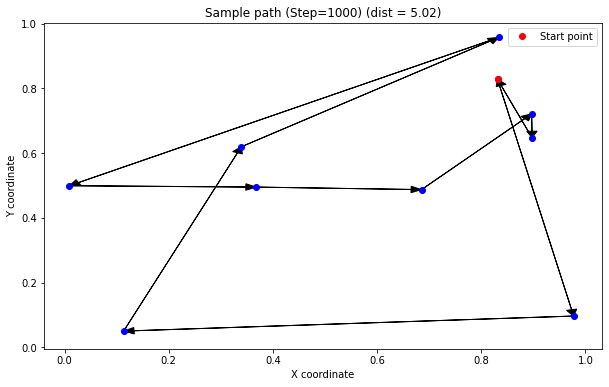

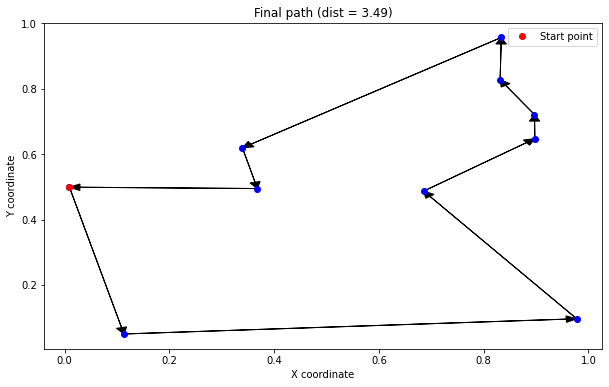

In [9]:
temperature = 5
run_experiments(city_coord,dist_matrix,num_mc_steps,
                    temperature,dt,steps_per_temp,final_temperature,
                    num_samples,step_to_sample)

### Experimento 2

Agora iremos testar o método para 30 pontos. Iremos testar agora dois valores de temperatura final para uma temperatura inicial de 5.

In [17]:
# Parâmetros para geração dos dados
data_seed = 2022
num_cities = 30

city_coord,dist_matrix = create_tsp_sample(num_cities,data_seed)

In [21]:
# Parâmetros para a simulação do TSP
num_mc_steps = 6000 # Passos de monte carlo
temperature = 5 # Temperatura inicial
dt = 0.8 # delta da temperatura, que será utilizado para fazer temp = temp * dt
steps_per_temp = 100 # passos entre aplicação do delta
final_temperature = 0.0005 # temperatura final
num_samples = 50 # número de amostras, i.e., caminhos iniciais distintos, a serem considerados na simulação
step_to_sample = 1500 # passo de monte carlo que será amostrado para comparação

  0%|          | 0/50 [00:00<?, ?it/s]

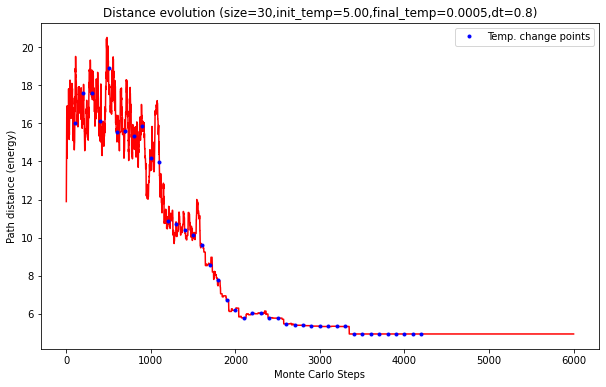

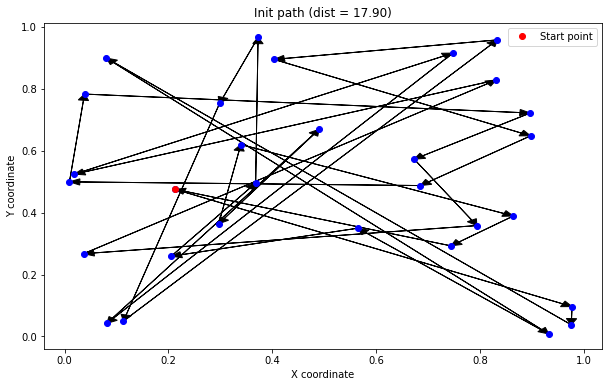

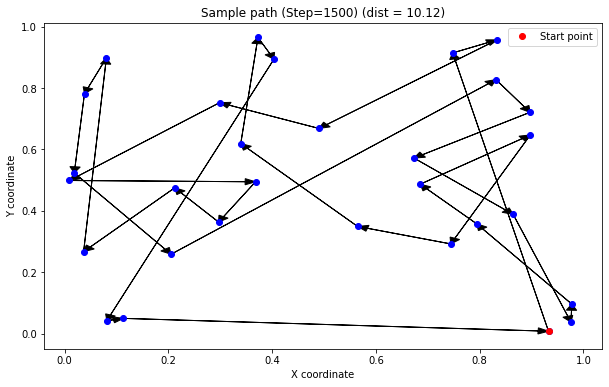

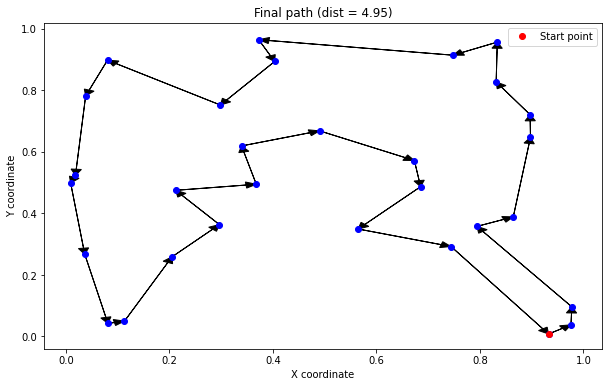

In [22]:
run_experiments(city_coord,dist_matrix,num_mc_steps,
                    temperature,dt,steps_per_temp,final_temperature,
                    num_samples,step_to_sample)

  0%|          | 0/50 [00:00<?, ?it/s]

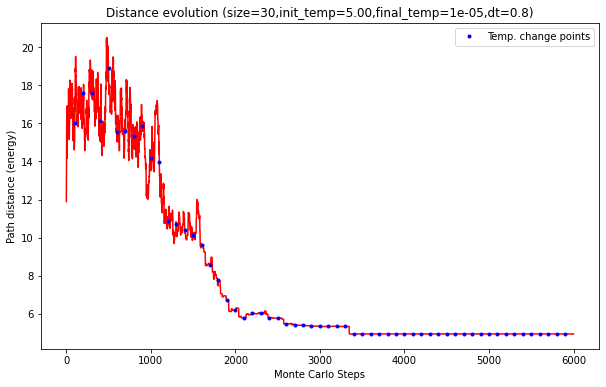

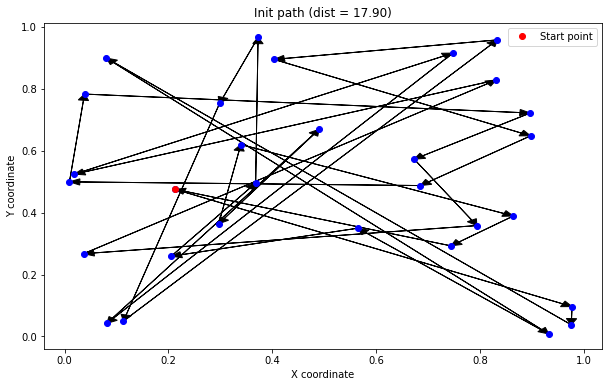

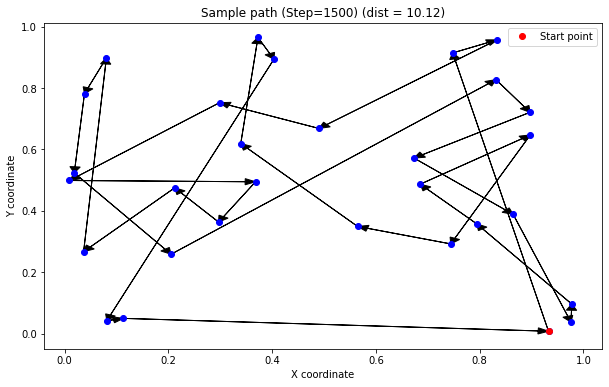

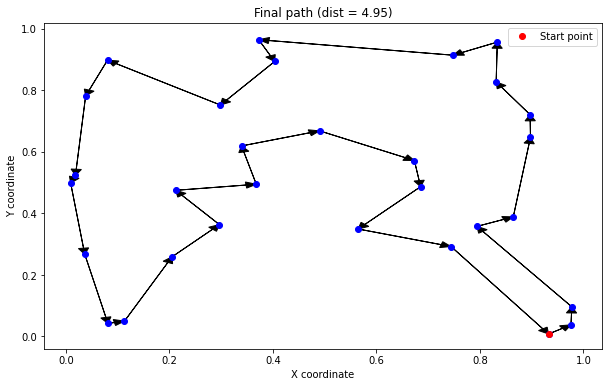

In [26]:
final_temperature = 0.00001
run_experiments(city_coord,dist_matrix,num_mc_steps,
                    temperature,dt,steps_per_temp,final_temperature,
                    num_samples,step_to_sample)

### Observações e Resultados

- Ao observarmos os gráficos de ambos os experimentos, nota-se o comportamento esperado: a distância total do caminho diminui a temperatura, i.e., sempre que diminuímos a temperatura, a distância tende a diminuir nos próximos passos. Isso é de se esperar, tendo em vista que a distância controla a probabilidade de aceitação de um novo caminho.
- É interessante também ver que maiores temperaturas inicias aumentam o número de passos necessários para atingir um valor estável, o que novamente é algo esperado para tal modelo.
- Ao observarmos os gráficos dos caminhos, podemos ver que de fato a simulação obtém um caminho final que aparenta estar próximo do ótimo. Podemos observar que os caminhos finais são singificativamente melhores que os iniciais.
- O experimento 2 também nos permite notar que valores de temperatura inicial diferentes não afetaram de forma significativa a performance final do modelo.
- De forma geral, observa-se que o método apresentado funciona muito bem para as configurações testadas. O ponto mais atrativo desse método é sua eficiência, dado que ele fornece uma solução significativamente boa em tempo polinomial para um problema NP-Completo. No entanto, o método possui diversos parâmetros que devem ser definidos pelo usuário, e portanto pode ser desafiador encontrar um conjunto de parâmetros que maximize a performance do modelo para um cenário qualquer.
- Por fim, conclui-se que o método apresentado é extremamente atrativo para a solução do problema em questão, além de possuir uma implementação simples para um problema que é reconhecidamente difícil.